In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.panda_mj_description import MJCF_PATH
from scripts.utils import update_actuator, ActuatorMotor

# np.random.seed(0)

In [2]:
MJCF_PATH = MJCF_PATH[:-len("panda.xml")] + "panda_nohand.xml"

In [3]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "link7")

ee_body

MJCF Element: <body name="link7" pos="0.087999999999999995 0 0" quat="1 1 0 0">...</body>

In [4]:
MJCF_PATH

'/home/simeon/.cache/robot_descriptions/mujoco_menagerie/franka_emika_panda/panda_nohand.xml'

In [5]:
# load_mass.add("inertial", mass=f"{M}", pos=f"{rc[0]} {rc[1]} {rc[2]}", diaginertia=f"{I} {I} {I}")

In [6]:
# old model
old_model = mujoco.MjModel.from_xml_path(MJCF_PATH)
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# create new body
rc = np.array([0.1, 0.05, -0.1])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1"
)

M = 2.0
# R = 0.0001
I = 1e-3#M * rc[0]**2

load_mass.add("inertial", mass=f"{M}", pos=f"0 0 0", diaginertia=f"{1e-3} {1e-3} {1e-3}")

# disable collision for all the geoms
for geom in mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)


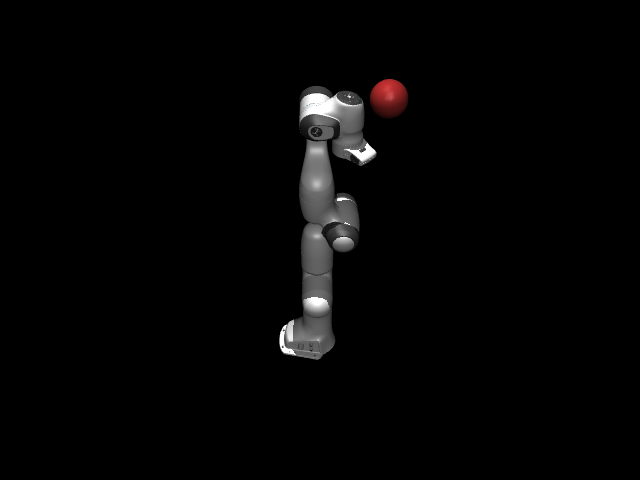

In [7]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [8]:
def staticload_joint_regressor(mj_model, mj_data, ee_id, active_joints = 7, body_offset = 0):

    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id+body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0,0,9.81]) #

    static_load_regressor = np.array([[a1, 0, 0, 0],
                                      [a2, 0, 0, 0],
                                      [a3, 0, 0, 0],
                                      [0, 0, a3, -a2],
                                      [0, -a3, 0, a1],
                                      [0, a2, -a1, 0]])
    
    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack((rotation.T@jac_lin[:, :active_joints],
                                   rotation.T@jac_rot[:, :active_joints]))
    joint_regressor = ee_local_jacobian.T @ static_load_regressor
    
    return joint_regressor

In [13]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq), np.zeros(sim_model.nq)
for jnt_idx in range(sim_model.nq):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

kp = 50
kd = 10
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

phase_time = 5.0
num_of_phases = 30
phases = 0
old_data.time = 0 
sim_data.time = 0

# print(sim_model.nq)
load_joint_regressor = np.zeros(((sim_model.nq)*num_of_phases, 4))
load_joint_force = np.zeros(((sim_model.nq))*num_of_phases)
active_joints = (sim_model.nq)

while sim_data.time < num_of_phases*phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (
        np.zeros(sim_model.nv) - sim_data.qvel
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl = sol

    if sim_data.time > phase_time * phases and sim_data.time < num_of_phases*phase_time: 
        # print(load_force)
        regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
        load_joint_regressor[7*phases: 7*(phases+1), :] = regressor
        
        load_qforce = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7*phases: 7*(phases+1)] = load_qforce.copy()
        actual_load_qforce = regressor@np.array([M,*(M*rc)])
        
        print(load_qforce)
        print(actual_load_qforce)
        print()
        
        phases += 1
        target_q = np.random.uniform(lower, upper)
        
         
    
    if len(frames) < sim_data.time * framerate:
        renderer.update_scene(sim_data)
        frames.append(renderer.render())
        

media.show_video(frames, fps=framerate)

[-169.76882795   36.29120925 -126.75137904   71.28179723    2.91496595
   -5.89653109   -3.16511198]
[ 1.98143965e-16  1.84610154e+00  5.13382236e+00  3.31768278e+00
  6.36312832e-01  8.64981154e-01 -3.35051394e-01]

[ 2.65043718e-05 -8.77995345e+00  6.06894864e+00 -5.66696198e-01
  2.23400339e+00 -7.38264629e-01  5.74053992e-01]
[ 6.17585301e-17 -8.78001359e+00  6.06899275e+00 -5.66700902e-01
  2.23401914e+00 -7.38256610e-01  5.74054339e-01]

[ 5.84163769e-06 -1.56021529e+00 -1.94193566e+00  3.78089894e+00
 -2.34704300e+00  1.24796352e+00 -2.76617391e-01]
[-5.71362815e-16 -1.56021421e+00 -1.94194231e+00  3.78089961e+00
 -2.34704991e+00  1.24796195e+00 -2.76620802e-01]

[ 18.26047228  -4.49276093  18.22448792 -10.14717229  -5.85580833
  10.02459378  -0.61759465]
[-5.69158531e-16  8.98287800e+00 -2.78555456e+00  4.19117862e+00
  1.32717116e+00  2.45576542e+00  1.69012032e+00]

[-7.68491693e-08 -2.55405079e+00 -2.29949404e+00  4.67832154e+00
 -1.73877016e+00  5.85555063e-01  1.63433331e+

In [10]:
params_estimates = np.linalg.pinv(load_joint_regressor[7:,:])@load_joint_force[7:]
mass = params_estimates[0]
coordinate = params_estimates[1:]/mass
mass, coordinate

(1.6039421123154205, array([ 0.12979459, -0.0078497 , -0.01772708]))

In [11]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),
    lambda x: (load_joint_regressor[7:] @ x - load_joint_force[7:]) ** 2,
)
estimates = result[0]
mass = estimates[0]
coordinate = estimates[1:]/mass
mass, coordinate

iter: 0    y: 3.849e+07  log10mu: -inf  ratio: 0.64     dx: 3.1      reduction: 1.2e+07
iter: 1    y: 2.635e+07  log10mu: -inf  ratio: 0.73     dx: 1.3      reduction: 2.9e+06
iter: 2    y: 2.349e+07  log10mu: -inf  ratio: 0.44     dx: 0.33     reduction: 1e+05  
iter: 3    y: 2.339e+07  log10mu: -inf  ratio: 0.53     dx: 0.17     reduction: 3.7e+04
iter: 4    y: 2.335e+07  log10mu: -inf  ratio: 0.49     dx: 0.084    reduction: 7.4e+03
iter: 5    y: 2.334e+07  log10mu: -inf  ratio: 0.51     dx: 0.042    reduction: 2e+03  
iter: 6    y: 2.334e+07  log10mu: -inf  ratio: 0.5      dx: 0.021    reduction: 4.8e+02
iter: 7    y: 2.334e+07  log10mu: -inf  ratio: 0.5      dx: 0.011    reduction: 1.2e+02
iter: 8    y: 2.334e+07  log10mu: -inf  ratio: 0.5      dx: 0.0053   reduction: 31     
iter: 9    y: 2.334e+07  log10mu: -inf  ratio: 0.5      dx: 0.0026   reduction: 7.7    
iter: 10   y: 2.334e+07  log10mu: -inf  ratio: 0.5      dx: 0.0013   reduction: 1.9    
iter: 11   y: 2.334e+07  log10mu

(-0.33878653689797505, array([-1.21515498,  2.72978804, -3.64186788]))

In [12]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: 0.22 actual: 0.27
joint 1 target: 0.98 actual: 0.88
joint 2 target: 1.82 actual: 1.59
joint 3 target: -2.62 actual: -2.69
joint 4 target: -0.35 actual: -0.39
joint 5 target: 0.66 actual: 0.56
joint 6 target: -0.02 actual: 0.04
